In this homework, we will practice modeling time series using data from the [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview). We will only work with the training data from this competition, and our task will be somewhat modified. The focus will be on finding the best model, conducting experiments, and utilizing the `darts` functionality.

## Store Item Demand Forecasting

**Objective:**  
The goal of this project is to develop a predictive model for daily sales of a single product in a specific store, using historical sales data. This will allow us to forecast sales for the next month on a daily basis and ultimately identify the best modeling approach for future applications across multiple products and stores.


**Dataset Description:**  
The dataset for this project is sourced from the [Store Item Demand Forecasting Challenge](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/overview) on Kaggle. It contains historical sales data for various products across multiple stores. The dataset includes columns such as:
- `date`: The date of the sales record.
- `store_id`: The identifier for the store.
- `item_id`: The identifier for the product.
- `sales`: The number of items sold on that date.

This dataset provides a comprehensive view of sales trends over time, enabling us to build effective forecasting models.



**Table of Contents**

* The problem statment
* Dataset description
* Load and explore the dataset
* Data preprocessing
* 
* 
* Make predictions on training and testing sets, analyze the results

### Exploring Data

Let's load and look at data

In [ ]:
# from google.colab import drive
# train_path = '/content/drive/MyDrive/data/time series/train.csv'
# drive.mount(train_path)

In [1]:
import pandas as pd
import numpy as np

train_path = 'data/train.csv'

df = pd.read_csv(train_path)
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


Let's convert the `date` column to a `datetime` format and set this date column as the index for easier data manipulation

In [2]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

df.head(10)

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
2013-01-06,1,1,12
2013-01-07,1,1,10
2013-01-08,1,1,9
2013-01-09,1,1,12


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB


We can see that there are no missing values 

Let's see how many items and stores are described in this data

In [5]:
df.item.nunique()

50

In [6]:
df.store.nunique()

10

We have 10 stores and 50 items in each. We want to understand if the dynamics of each item differ across the stores. Let's visualize it

In [7]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

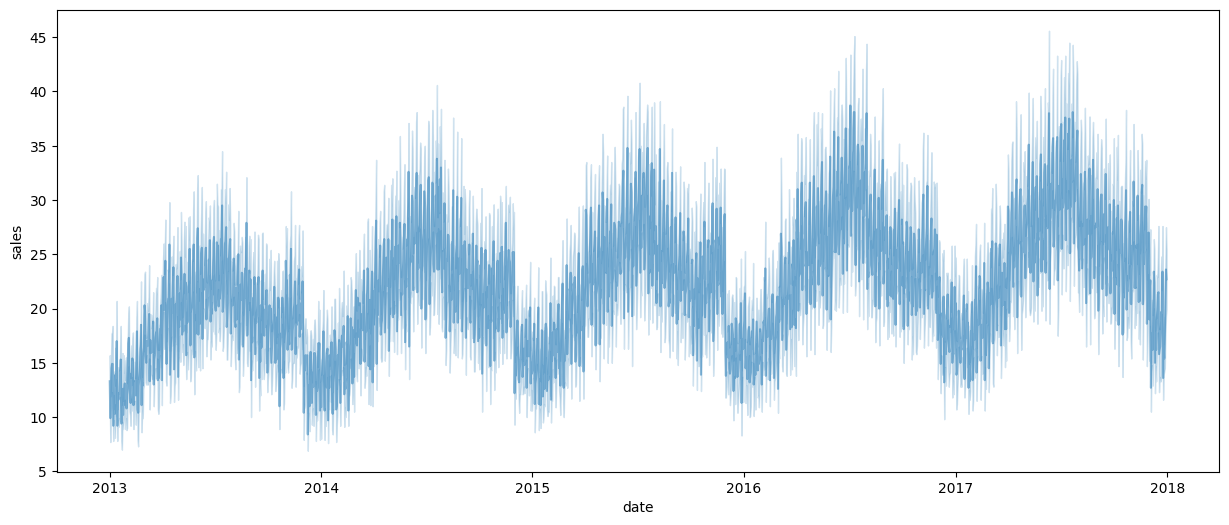

In [8]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=df[df.item == 1], x='date', y='sales', alpha=0.5);

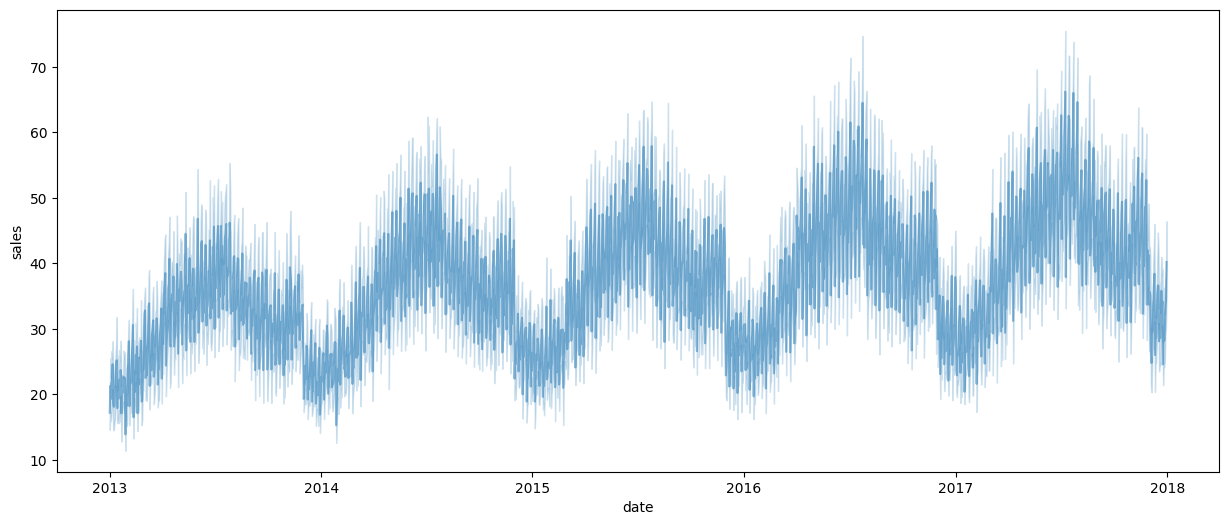

In [9]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=df[df.item == 3], x='date', y='sales', alpha=0.5);

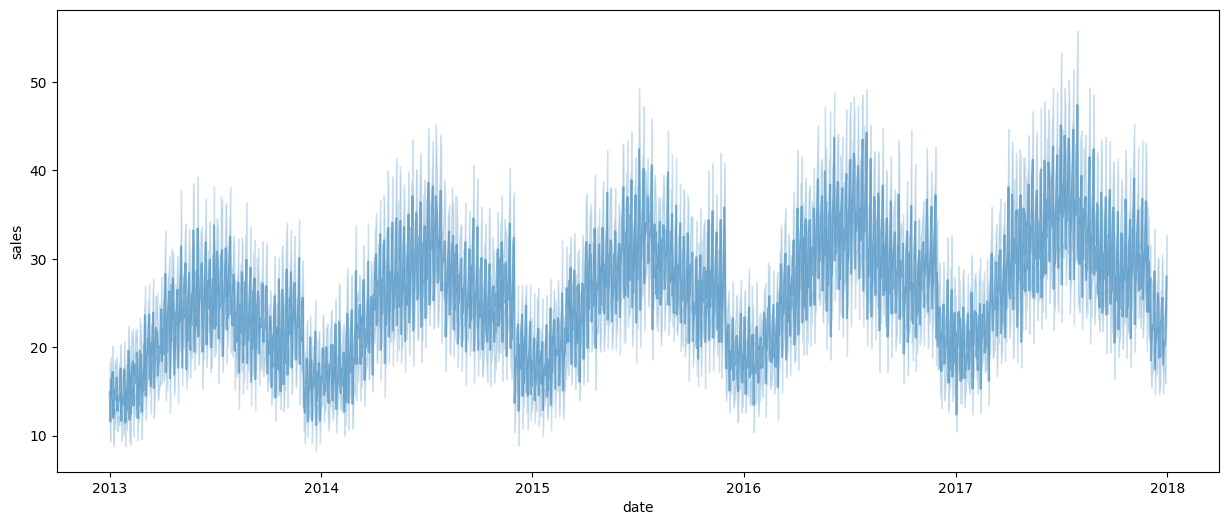

In [10]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=df[df.item == 34], x='date', y='sales', alpha=0.5);

We can see that for different products the sales dynamics are similar, but the volumes differ.

#### Decomposition

To begin with, let's analyze just one series

Let's select a subset of the data corresponding to the sales of the product with `item == 1` in the store with `store == 1` and perform a decomposition using an additive model into trend, seasonality, and residuals with the `statsmodels` library


In [ ]:
df_item1_store1 = pd.DataFrame(df[(df.item == 1) & (df.store == 1) ]['sales'])

df_item1_store1.head()

,sales
date,
2013-01-01,13
2013-01-02,11
2013-01-03,14
2013-01-04,13
2013-01-05,10


In [9]:
latest_date = df_item1_store1.index.max()
last_two_months = df_item1_store1.loc[df_item1_store1.index >= latest_date - pd.Timedelta(days=60)]

In [10]:
freq = pd.infer_freq(last_two_months.index)
print(freq)

D


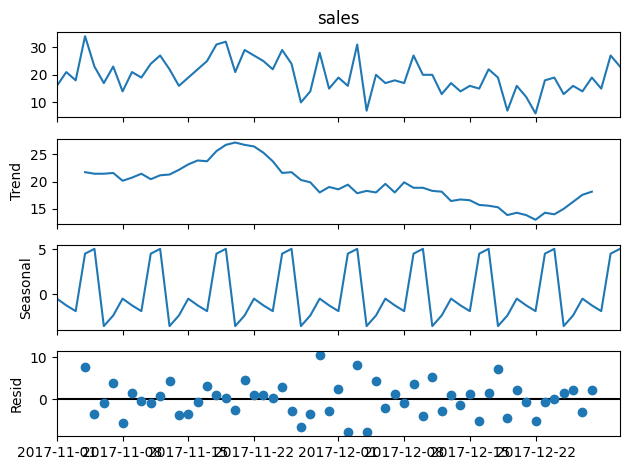

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition_plot_multi = seasonal_decompose(last_two_months['sales'],
                                              model='additive')

decomposition_plot_multi.plot()
plt.show()

From the visualization, it is clear that the data has quite a few residuals, and they have a noticeable deviation relative to the range of the data. It is also possible to see some dependence in the distribution of the residuals.

From the created subset of data in the previous point let's create an object of the `TimeSeries` class in `darts` only for the `sales` column

In [13]:
from darts import TimeSeries

series  = TimeSeries.from_dataframe(df_item1_store1, value_cols='sales')
series

<TimeSeries (DataArray) (date: 1826, component: 1, sample: 1)> Size: 15kB
array([[[13.]],

       [[11.]],

       [[14.]],

       ...,

       [[15.]],

       [[27.]],

       [[23.]]])
Coordinates:
  * date       (date) datetime64[ns] 15kB 2013-01-01 2013-01-02 ... 2017-12-31
  * component  (component) object 8B 'sales'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

Now let's split the data into training and validation sets so that the validation starts from `2017-10-01` inclusive.

<Axes: xlabel='date'>

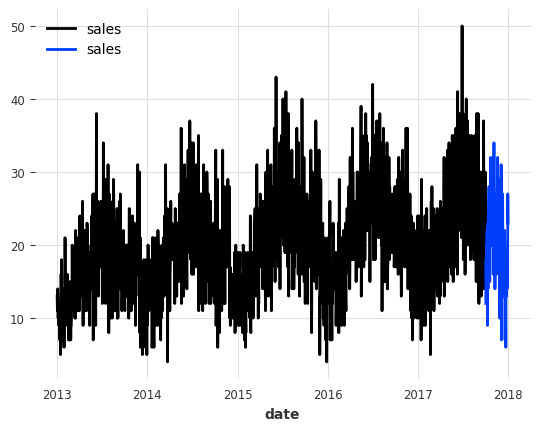

In [ ]:
series_train, series_val = series.split_after(pd.Timestamp('2017-10-01'))
series_train.plot()
series_val.plot()

#### PACF

Let's build the partial autocorrelation function to see which lags are important for forecasting

In [15]:
from statsmodels.graphics.tsaplots import plot_pacf

<Figure size 1000x600 with 0 Axes>

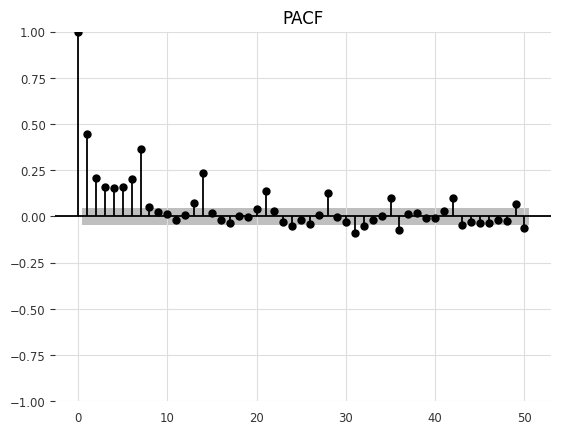

In [16]:
plt.figure(figsize=(10, 6))
plot_pacf(df_item1_store1, lags=50, method='ywm')
plt.title('PACF')
plt.show()

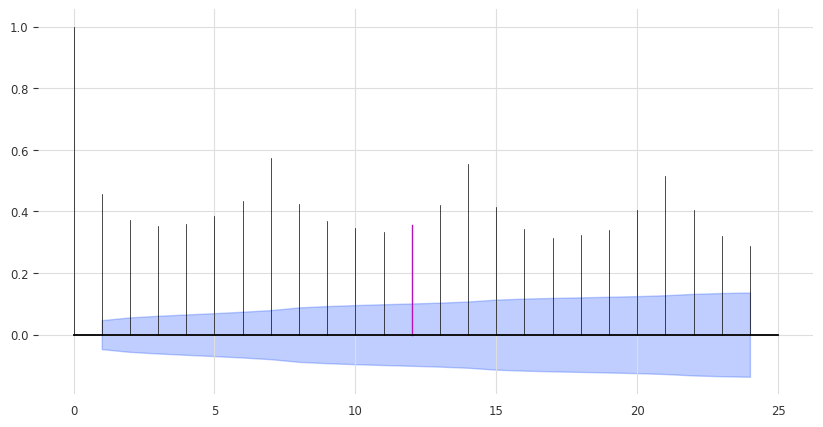

In [17]:
from darts.utils.statistics import plot_acf

plot_acf(series_train, m = 12,  alpha=0.05, max_lag=24)

From the constructed graph of the partial autocorrelation function, it is evident that every 7th lag has the greatest influence.

Now let's dentify the seasonality of the training series using the `check_seasonality` function from `darts`.

In [18]:
from darts.utils.statistics import check_seasonality

for m in range(2, 25):
    is_seasonal, period = check_seasonality(series_train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 7.
There is seasonality of order 14.
There is seasonality of order 21.


### Naive models

Let's start with naive model `NaiveSeasonal` + `NaieDrift` for forecasting the data

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning:


Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.




<Axes: xlabel='date'>

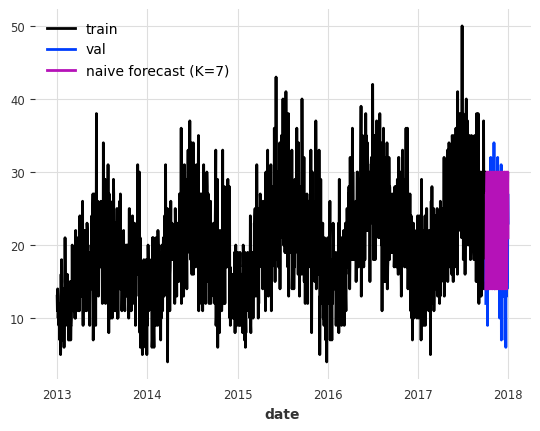

In [ ]:
from darts.models import NaiveDrift, NaiveSeasonal

# NaiveSeasonal model for seasonality forecasting
naive_seasonal = NaiveSeasonal(K=7)
naive_seasonal.fit(series_train)
naive_seasonal_pred = naive_seasonal.predict(len(series_val))

series_train.plot(label="train")
series_val.plot(label="val")
naive_seasonal_pred.plot(label="naive forecast (K=7)")



In [21]:
len(series_val)

91

The resulting graph displays too many data points at once; let's show only a portion of the predictions for better understanding.

<Axes: xlabel='date'>

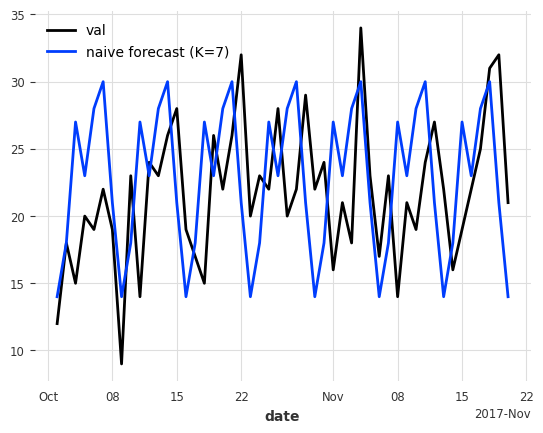

In [22]:
series_val[:50].plot(label="val")
naive_seasonal_pred[:50].plot(label="naive forecast (K=7)")


<Axes: xlabel='date'>

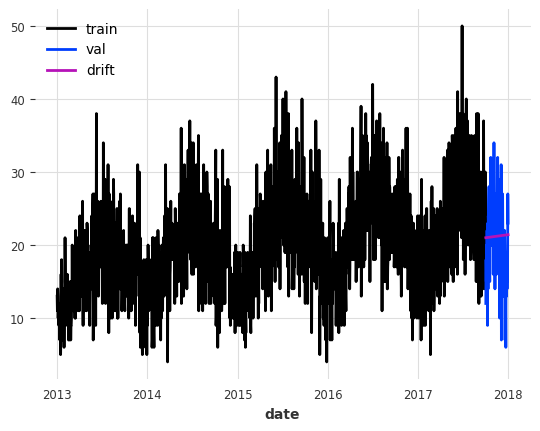

In [ ]:
# naive drift model for trend forecasting
naive_drift = NaiveDrift()
naive_drift.fit(series_train)
naive_drift_pred = naive_drift.predict(len(series_val))

series_train.plot(label='train')
series_val.plot(label="val")
naive_drift_pred.plot(label="drift")

<Axes: xlabel='date'>

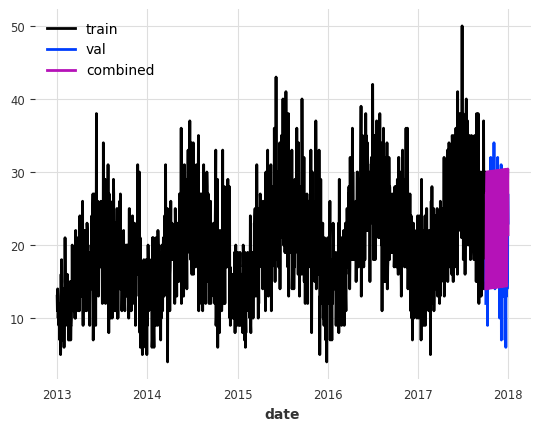

In [ ]:
# combining results
combined_forecast = naive_drift_pred + naive_seasonal_pred - series_train.last_value()

series_train.plot(label="train")
series_val.plot(label="val")

combined_forecast.plot(label="combined")


<Axes: xlabel='date'>

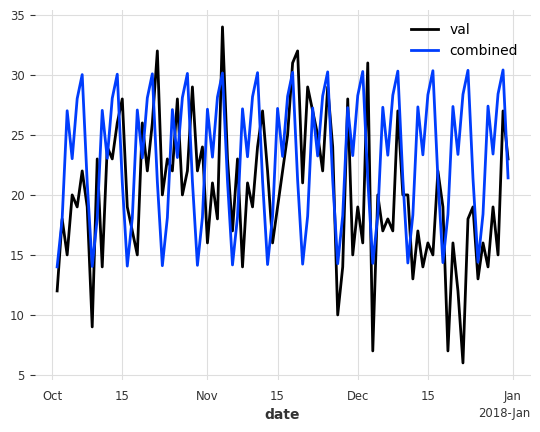

In [25]:
series_val.plot(label="val")
combined_forecast.plot(label="combined")


The obtained model, although it captures the trend in the data, is not accurate enough, as can be seen from the visualization.

Let's calculate the forecast error on validation using the naive model with `mape`

In [26]:
from darts.metrics import mape

def get_mape(forecast, model_name):
  print(
      f"MAPE for {model_name}: {mape(series, forecast):.2f}%."
  )

get_mape(combined_forecast, 'Combined naive drift + Seasonal')

MAPE for Combined naive drift + Seasonal: 39.47%.


### XBGModel

Now let's train the `XBGModel from darts` and add additional features to enrich the data with additional date features by extracting various components from the `date` column, such as hour, day of the week, quarter, year, day of the year, and day of the month. 

Let's also calculate the sine and cosine of the day of the year to capture seasonal patterns

In [27]:
from darts.models import XGBModel
from darts.dataprocessing.transformers import Scaler

In [28]:
series_train.pd_dataframe()

component,sales
date,
2013-01-01,13.0
2013-01-02,11.0
2013-01-03,14.0
2013-01-04,13.0
2013-01-05,10.0
...,...
2017-09-27,27.0
2017-09-28,23.0
2017-09-29,28.0


In [ ]:

def enrich_with_date_features(df):

  df["hour"] = df['date'].dt.hour
  df["dayofweek"] = df['date'].dt.dayofweek
  df["quarter"] = df['date'].dt.quarter
  df["year"] = df['date'].dt.year
  df["dayofyear"] = df['date'].dt.dayofyear
  df["sin_day"] = np.sin(df["dayofyear"])
  df["cos_day"] = np.cos(df["dayofyear"])
  df["dayofmonth"] = df['date'].dt.day

  return df

# Adding features
train_transformed = enrich_with_date_features(series_train.pd_dataframe().reset_index())
val_transformed = enrich_with_date_features(series_val.pd_dataframe().reset_index())

# Data scaling
scaler = Scaler()
train_transformed = scaler.fit_transform(series_train)
test_transformed = scaler.transform(series_val)

xgb_model = XGBModel(

    # lags=14,
    lags=7,
    output_chunk_length=1,
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8
)



In [30]:
xgb_model.fit(train_transformed)
pred = xgb_model.predict(6)
pred.values()

array([[0.35704038],
       [0.3894598 ],
       [0.4541336 ],
       [0.42094207],
       [0.47126928],
       [0.48382398]], dtype=float32)

In [31]:
def plot_pred(forecast, zoom=False):
  if zoom:
    series_train[-50:].plot(label='Train Data')
  else:
    series_train.plot(label='Train Data')

  series_val.plot(label="Val Data")
  forecast.plot(label='Forecast', color='red')

  plt.legend()
  plt.show()

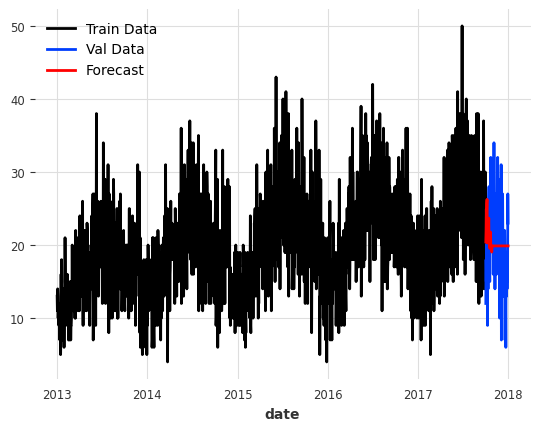

In [32]:
forecast = scaler.inverse_transform(xgb_model.predict(len(series_val)))

plot_pred(forecast, zoom=False)

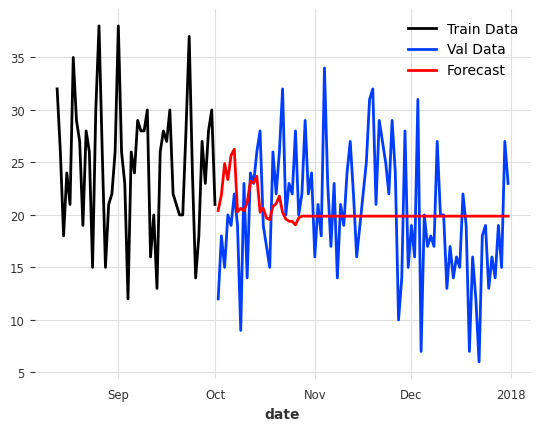

In [33]:
plot_pred(forecast, zoom=True)


In [34]:
get_mape(forecast, 'XGB Model')

MAPE for XGB Model: 29.22%.


The MAPE value for the obtained model is slightly better than that of the naive model, however, in the visualization of predictions against actual data, it is clear that the model still provides unaccurate results

### ExponentialSmoothing model

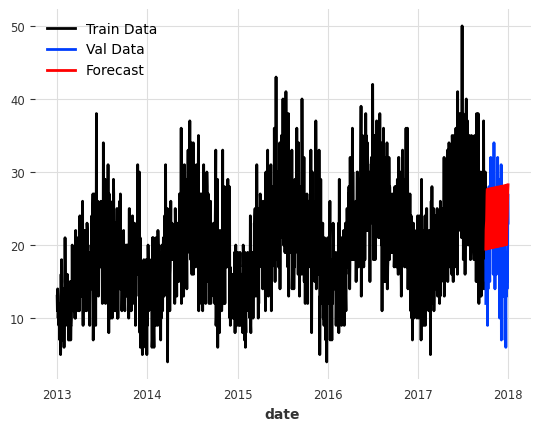

In [35]:
from darts.models import ExponentialSmoothing

es_model = ExponentialSmoothing()
es_model.fit(series_train)
forecast = es_model.predict(len(series_val))

plot_pred(forecast)

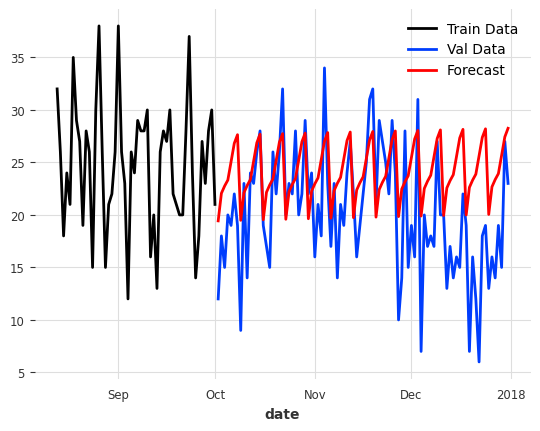

In [36]:
plot_pred(forecast, zoom=True)


In [37]:
get_mape(forecast, "Exponential Smoothing Model")


MAPE for Exponential Smoothing Model: 36.16%.


Visually, the model's results look better than the previous one, but the MAPE value is higher and it is still not accurate enough.

### ARIMA model

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



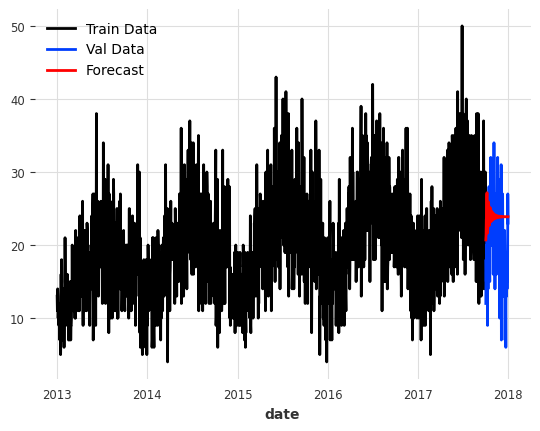

In [38]:
from darts.models import ARIMA

arima = ARIMA(p=12, d=1, q=1)
arima.fit(series_train)
forecast = arima.predict(len(series_val))

plot_pred(forecast)


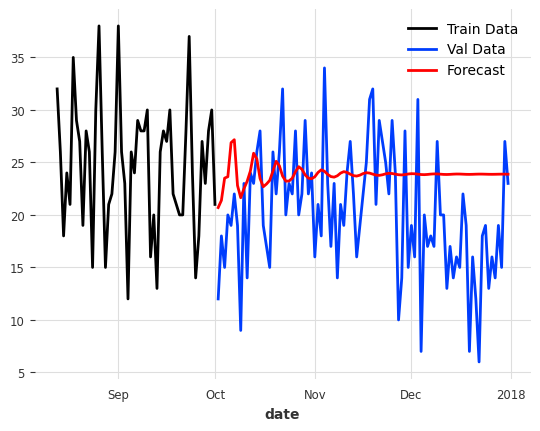

In [39]:
plot_pred(forecast, zoom=True)


In [40]:
get_mape(forecast, 'ARIMA')

MAPE for ARIMA: 37.94%.


In [41]:
?ARIMA

The MAPE value for the model is worse than in the previous one, and the visualization shows that the model is insufficiently accurate

### AutoARIMA model
Let's perform a parameter search and see if the quality improved compared to the previous experiment

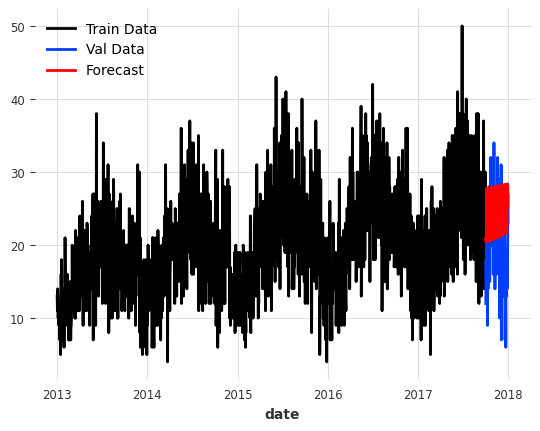

In [42]:
from darts.models import AutoARIMA

auto_arima = AutoARIMA(start_p=3, max_p=7, start_q=3)
auto_arima.fit(series_train)

forecast = auto_arima.predict(len(series_val))

plot_pred(forecast)


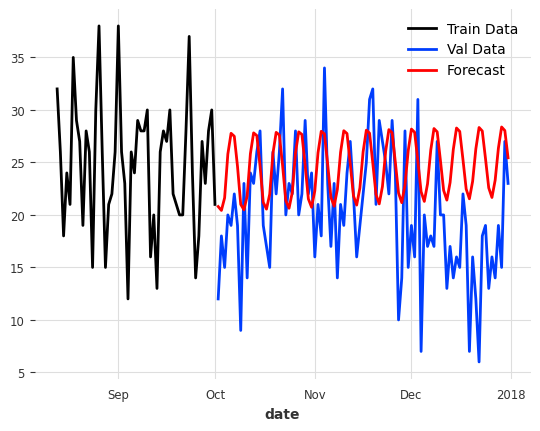

In [43]:
plot_pred(forecast, zoom=True)


In [44]:
auto_arima.model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1735
Model:               SARIMAX(4, 1, 5)   Log Likelihood               -5228.788
Date:                Wed, 25 Sep 2024   AIC                          10479.575
Time:                        20:32:54   BIC                          10539.616
Sample:                             0   HQIC                         10501.780
                               - 1735                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0339      0.030      1.135      0.256      -0.025       0.093
ar.L1         -0.5148      0.028    -18.647      0.000      -0.569      -0.461
ar.L2          0.2532      0.014     17.861      0.000       0.225       0.281
ar.L3         -0.5824      0.013    -45.107      0.000      -0.608      -0.557
ar.L4         -0.9369      0.026    -36.011      0.000      -0.988      -0.886
ma.L1         -0.4157      0.039    -10.765      0.000      -0.491      -0.340
ma.L2         -0.7194      0.050    -14.288      0.000      -0.818      -0.621
ma.L3          0.8193      0.031     26.382      0.000       0.758       0.880
ma.L4          0.3537      0.047      7.551      0.000       0.262       0.446
ma.L5         -0.7931      0.035    -22.450      0.000      -0.862      -0.724
sigma2        24.5947      0.767     32.046      0.000      23.091      26.099
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                27.56
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               1.32   Skew:                             0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
get_mape(forecast, 'Auto ARIMA')


MAPE for Auto ARIMA: 40.15%.


The quality of the model parameters obtained through automatic tuning did not improve

### Prophet model

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6tbq3foc/bsdudott.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6tbq3foc/u72e9fcu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56025', 'data', 'file=/tmp/tmp6tbq3foc/bsdudott.json', 'init=/tmp/tmp6tbq3foc/u72e9fcu.json', 'output', 'file=/tmp/tmp6tbq3foc/prophet_model_172tdm8/prophet_model-20240925203254.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:32:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:32:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


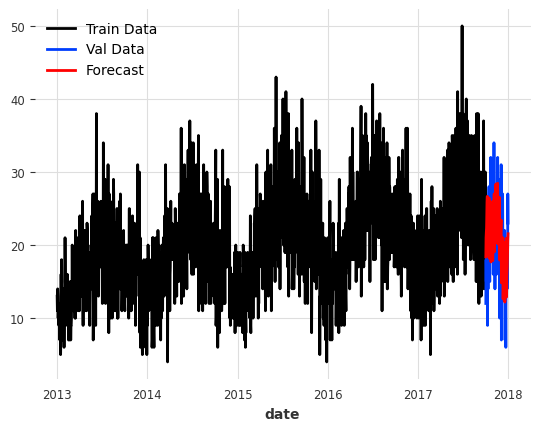

In [46]:
from darts.models import Prophet

prophet = Prophet()
prophet.fit(series_train)

forecast = prophet.predict(len(series_val))

plot_pred(forecast)


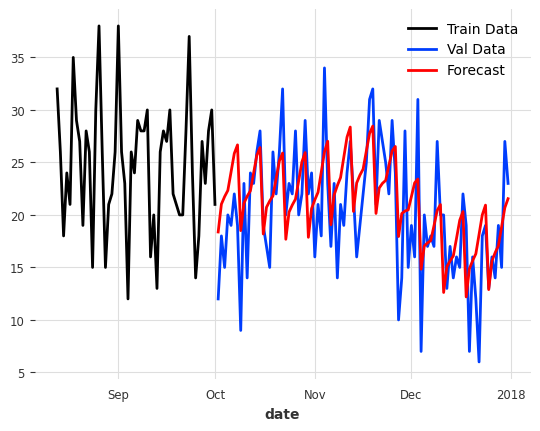

In [47]:
plot_pred(forecast, zoom=True)


In [48]:
get_mape(forecast, 'Prophet')


MAPE for Prophet: 23.67%.


The obtained Prophet model provides quite good results compared to previous models, having a significantly better MAPE score.

### `RNNModel` 

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.8 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
2.8 K     Trainable params
0         Non-trainable p

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=700` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

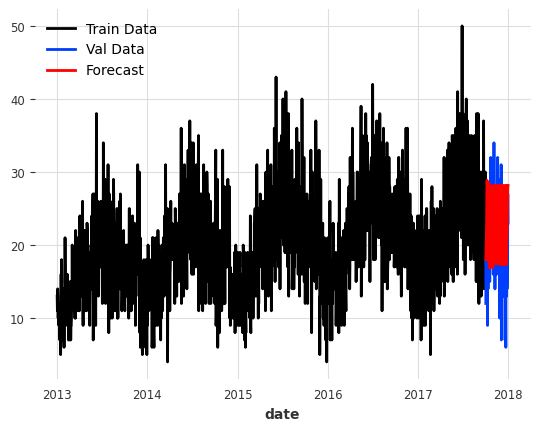

In [49]:
from darts.models import RNNModel

EPOCHS = 700

rnn = RNNModel(model='LSTM', input_chunk_length=12, n_epochs=EPOCHS)
rnn.fit(series_train)

forecast = rnn.predict(len(series_val))

plot_pred(forecast)

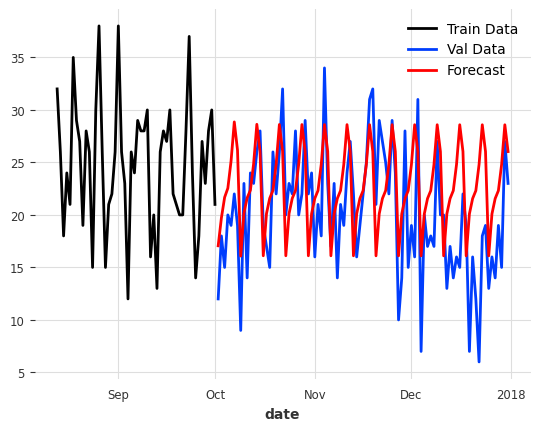

MAPE for RNN 700 epochs: 32.42%.


In [ ]:
plot_pred(forecast, zoom=True)
get_mape(forecast, f'RNN {EPOCHS} epochs')


The RNN model performed better than simpler models, but worse than Prophet.

### Backtestig

Now let's perform a backtest for the model that turned out to be the best(Prophet) over a period of `1 year` with predictions for `1 month` each time

In [ ]:
hfc_params = {
    'series': series,
    'start': pd.Timestamp('2017-01-01'),
    'forecast_horizon': 1,
    'verbose': True
}

hfc = prophet.historical_forecasts(last_points_only=True, **hfc_params)

MAPE for BT: 20.89%.


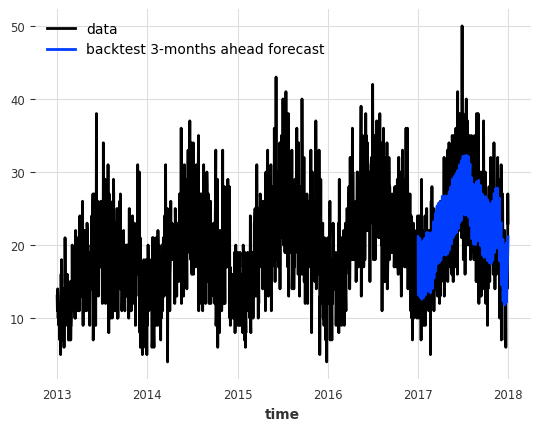

In [52]:
series.plot(label="data")
hfc.plot(label="backtest 3-months ahead forecast")
# print(f"MAPE = {mape(series, historical_fcast):.2f}%")
get_mape(hfc, 'BT')

In [ ]:
raw_errors = prophet.backtest(metric=mape, reduction=None, last_points_only=False, stride=1, **hfc_params)

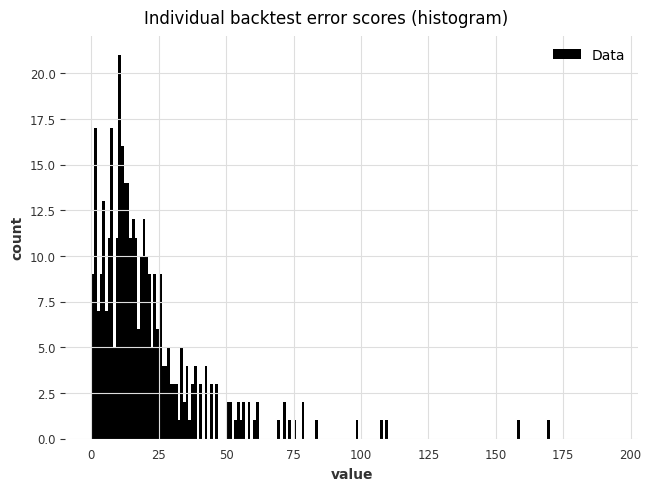

In [58]:
from darts.utils.statistics import plot_hist

plot_hist(
    raw_errors,
    bins=np.arange(0, max(raw_errors), 1),
    title="Individual backtest error scores (histogram)",
)

The prophet model showed good results during backtesting, even slightly better than simple forecasting.

### Conclusions

The analysis revealed that the demand forecasting model achieved a high level of accuracy with `MAPE score 20.9%` on `Prophet` model. The model effectively captured the seasonal trends and patterns in the sales data, allowing for reliable demand predictions.